In [1]:
from joblib import load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plot_config
plot_config.set_config()

In [2]:
experiment = 'elec2'
name_caps = 'Electricity'

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


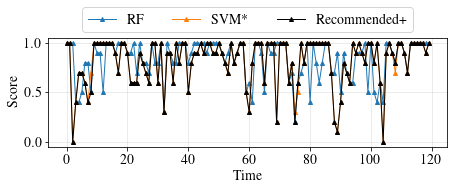

In [3]:
rf_score = load('../data/'+experiment+'/score_rf.joblib')[:120]
svm_score = load('../data/'+experiment+'/score_svm.joblib')[:120]
score_recommended = np.array(load('../data/'+experiment+'/score_reco.joblib'))[:120]
fig = plt.gcf()
fig.set_size_inches(7.14, 2)
plt.plot(rf_score, '^-', label='RF')
plt.plot(svm_score, '^-', label='SVM*')
plt.plot(score_recommended, 'k^-', label='Recommended+')
plt.xlabel('Time')
plt.ylabel('Score')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=3, fancybox=True)
plt.savefig(experiment+'_tscores.pdf', bbox_inches='tight')

In [4]:
exps_fi = {}
for exp in ['elec2', 'covtype', 'powersupply']:
    t_importance = load('../data/'+exp+'/importance.joblib')
    t_fname = load('../data/'+exp+'/fnames.joblib')[:-1]
    exps_fi[exp] = dict(sorted(zip(t_fname,t_importance), key=lambda x: x[1], reverse=True)[:5])
    
#t_importance = load('../data/'+experiment+'/importance.joblib')
#t_fname = load('../data/'+experiment+'/fnames.joblib')[:-1]
    
#dic = sorted([(k,v) for k,v in zip(t_importance, t_fname)])[-5:]
#importance = [k for k,v in dic]
#fname = [v for k,v in dic]
pos = np.arange(4,-1,-1)

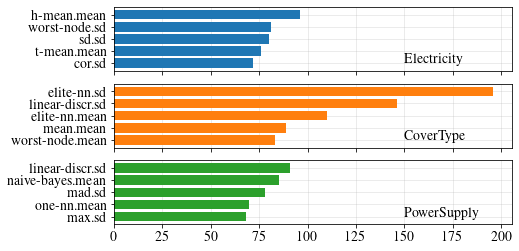

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True)
fe2 = exps_fi['elec2']
ax1.barh(pos, fe2.values(), align='center', tick_label=[x.replace('_','-') for x in fe2.keys()], label='Electricity')

ax1.text(150, 0, 'Electricity')

fct = exps_fi['covtype']
ax2.barh(pos, fct.values(), align='center', tick_label=[x.replace('_','-') for x in fct.keys()], color='C1',
         label='CoverType')
ax2.text(150, 0, 'CoverType')

fps = exps_fi['powersupply']
ax3.barh(pos, fps.values(), align='center', tick_label=[x.replace('_','-') for x in fps.keys()], color='C2',
        label='PowerSupply')
ax3.text(150, 0, 'PowerSupply')

fig.set_size_inches(7.14, 4)
plt.savefig('general_fi.pdf', bbox_inches='tight')

In [6]:
translate = {'elec2':'Electricity', 'covtype':'CoverType', 'powersupply':'PowerSupply'}

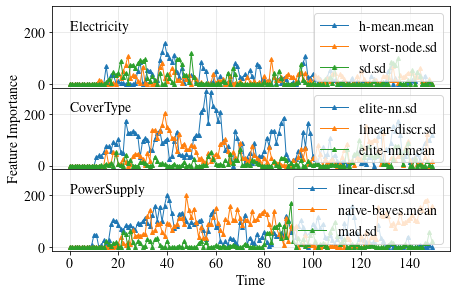

In [7]:
fig, ax = plt.subplots(3, sharex=True, sharey=True, gridspec_kw={'hspace': 0})

for i, exp in enumerate(['elec2', 'covtype', 'powersupply']):
    tfi = load('../data/'+exp+'_ninc/tfi.joblib')[:150]
    topfname = list(exps_fi[exp].keys())[:3]
    t_fname = load('../data/'+exp+'/fnames.joblib')[:-1]
    tfi = pd.DataFrame(tfi, columns=t_fname)[topfname]
    tfi.rename(columns={x:x.replace('_','-') for x in topfname}, inplace=True)
    ax[1].set_ylabel('Feature Importance')
    ax[i].text(0, 210, translate[exp])
    for cols in tfi.iteritems():
        ax[i].plot(cols[1], '^-', label=cols[0])
        ax[i].legend(loc='right')

fig.set_size_inches(7.14, 4.5)
plt.xlabel('Time')
plt.savefig('general_timefi.pdf', bbox_inches='tight')

In [8]:
arange = 1000
difference = np.array(load('../data/'+experiment+'/difference.joblib'))
difference_ninc = np.array(load('../data/'+experiment+'_ninc/difference.joblib'))
cum = np.cumsum(difference)[:arange]
cum_ninc = np.cumsum(difference_ninc)[:arange]
x = np.arange(arange)

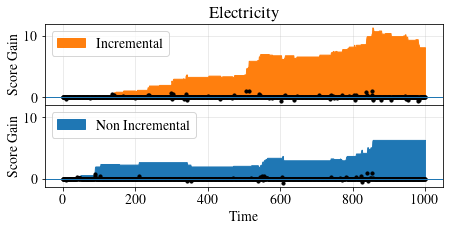

In [9]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True, gridspec_kw={'hspace': 0})

ax1.fill_between(x, cum, 0, color='C1', label='Incremental')
ax1.scatter(x, difference[:arange], s=10, c='black')
ax1.set_title(name_caps)
ax1.axhline(0)
ax1.legend(loc='upper left')
ax1.set_ylabel('Score Gain')

ax2.fill_between(x, cum_ninc, 0, color='C0', label='Non Incremental')
ax2.scatter(x, difference_ninc[:arange], s=10, c='black')
ax2.axhline(0)
ax2.legend(loc='upper left')
ax2.set_ylabel('Score Gain')
ax2.set_xlabel('Time')

fig = plt.gcf()
fig.set_size_inches(7.14, 3)
plt.savefig(experiment+'_cumsum.pdf', bbox_inches='tight')

In [10]:
print(cum[-10:])

[8.1 8.1 8.1 8.1 8.1 8.1 8.1 8.1 8.1 8.1]


In [11]:
with open('../'+experiment.replace('_','-')+'.output') as fin:
    print(fin.read())

[GENERATE METAFEATURE]
Frequency statistics in metabase:
	Pipeline                 0.752
	RandomForestClassifier   0.247
[OFFLINE LEARNING]
Kappa:    -0.004+-0.222
GMean:    0.092+-0.221
Accuracy: 0.706+-0.188
[ONLINE LEARNING]
Kappa:  0.022239162336220364
GMean:  0.5092511272941179
Accuracy:  0.5452328700316996
              precision    recall  f1-score   support

           0       0.75      0.58      0.65      3040
           1       0.27      0.45      0.34      1061

    accuracy                           0.55      4101
   macro avg       0.51      0.51      0.50      4101
weighted avg       0.63      0.55      0.57      4101

                   pre       rec       spe        f1       geo       iba       sup

          0       0.75      0.58      0.45      0.65      0.51      0.26      3040
          1       0.27      0.45      0.58      0.34      0.51      0.26      1061

avg / total       0.63      0.55      0.48      0.57      0.51      0.26      4101




In [12]:
metadf = load('../data/'+experiment+'/metadf.joblib')
best = np.array(load('../data/'+experiment+'/best.joblib'))
score_recommended = np.array(load('../data/'+experiment+'/score_reco.joblib'))
score_default = np.array(load('../data/'+experiment+'/score_def.joblib'))


score_recommended_ninc = np.array(load('../data/'+experiment+'_ninc/score_reco.joblib'))
score_default_ninc = np.array(load('../data/'+experiment+'_ninc/score_def.joblib'))

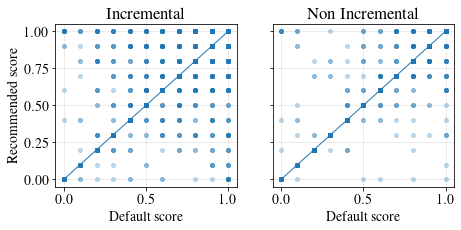

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

ax1.scatter(score_default, score_recommended, alpha=.25)
ax1.set_ylabel('Recommended score')
ax1.set_title('Incremental')
ax1.set_xlabel('Default score')
ax1.plot([0,1])

ax2.scatter(score_default_ninc, score_recommended_ninc, alpha=.25)
ax2.set_title('Non Incremental')
ax2.set_xlabel('Default score')
ax2.plot([0,1])

fig = plt.gcf()
fig.set_size_inches(7.14, 3)
plt.savefig(experiment+'_score.pdf', bbox_inches='tight')